In [2]:
import os
import time
import shutil
import tempfile
from glob import glob
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader, decollate_batch, ImageDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    Resized
)
from monai.utils import set_determinism

import torch
import pandas as pd
#print_config()

In [3]:
columns = ['case','is_use']
positive_case = pd.read_csv('./cases/positive_case.csv', header=None, names=columns)
positive_case = positive_case[positive_case["is_use"] == 1]
positive_case["case"] = "cases/labels/" + positive_case["case"] + ".nii.gz"

file_list = []
for i in range(len(positive_case)):
    file_list.append(positive_case.iloc[i, 0])
print(f"{len(file_list)} images")

65 images


In [4]:
list_data  = [ {'image0':f.replace('labels','images').replace('.nii','_0000.nii'),
                'image1':f.replace('labels','images').replace('.nii','_0001.nii'),
                'image2':f.replace('labels','images').replace('.nii','_0002.nii'),
                'label':f } for f in file_list ]

In [5]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        #ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)



class ConvertToMultiChannel(MapTransform):
    def __call__(self, data):
        data['image'] = torch.concat([data['image0'],data['image1'],data['image2']], dim=0)
        del data['image0'], data['image1'], data['image2']
        del data['image0_meta_dict'], data['image1_meta_dict'], data['image2_meta_dict'], data['label_meta_dict']
        return data
        
train_transform = Compose(
    [
        LoadImaged(keys=["image0", "image1","image2", "label"]),
        EnsureChannelFirstd(keys=["image0", "image1","image2", "label"]),
        EnsureTyped(keys=["image0", "image1","image2", "label"]),
        ConvertToMultiChannel(keys=["image0", "image1","image2"]),
        RandSpatialCropd(keys=["image", "label"], roi_size=[120, 120, 8]),
        Resized(keys=["image", "label"], spatial_size=[240, 240, 16], mode=['area', 'nearest']),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

/home/mpmri/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/home/mpmri/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary RandSpatialCropd.__init__:random_size: Current default value of argument `random_size=True` has been deprecated since version 1.1. It will be changed to `random_size=False` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [6]:
ds = Dataset(list_data, transform=train_transform)
dl = DataLoader(ds, batch_size=1, shuffle=True)

torch.Size([3, 240, 240, 16])
torch.Size([1, 240, 240, 16])


<Figure size 640x480 with 0 Axes>

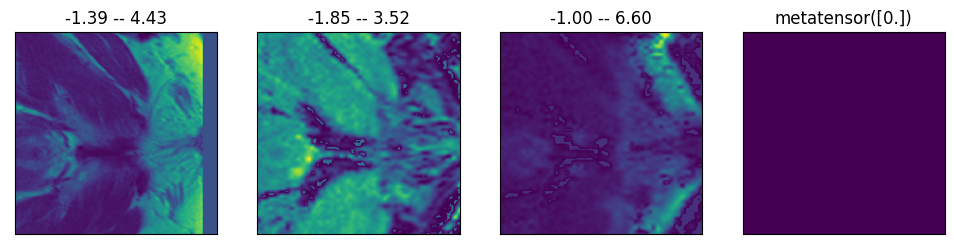

<Figure size 640x480 with 0 Axes>

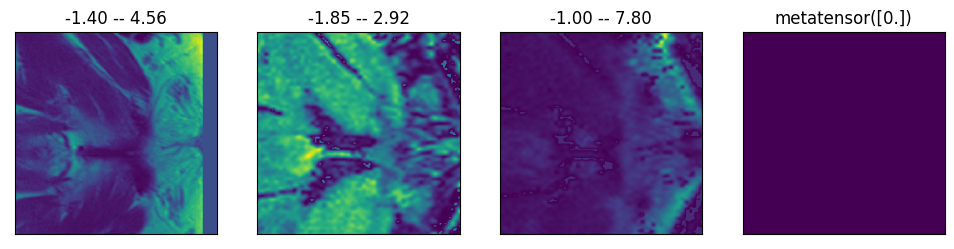

<Figure size 640x480 with 0 Axes>

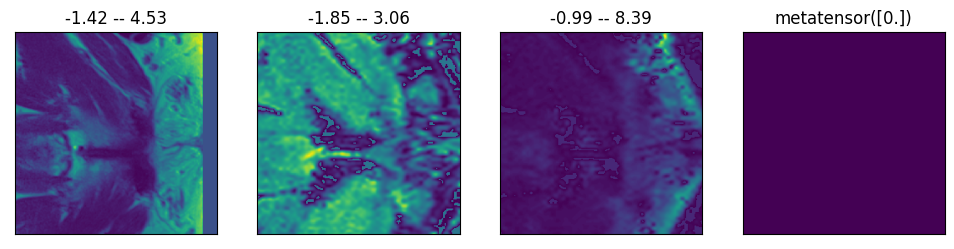

<Figure size 640x480 with 0 Axes>

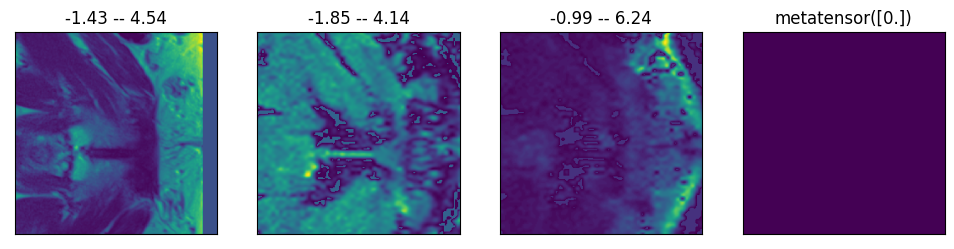

<Figure size 640x480 with 0 Axes>

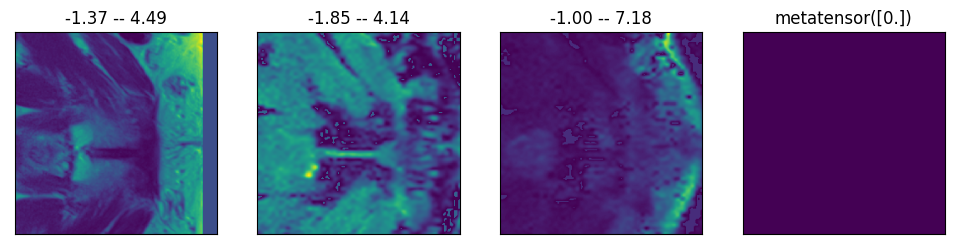

In [7]:
one_batch = ds[10]
print(one_batch['image'].shape)
print(one_batch['label'].shape)
for i in range(5,10):
    plt.figure()
    image = one_batch['image']
    label = one_batch['label']
    plt.figure(figsize=(12,6))
    plt.subplot(141), plt.imshow(image[0,:,:,i]), plt.title(f"{image[0,:,:,i].min():.2f} -- {image[0,:,:,i].max():.2f}"), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(image[1,:,:,i]), plt.title(f"{image[1,:,:,i].min():.2f} -- {image[1,:,:,i].max():.2f}"), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(image[2,:,:,i]), plt.title(f"{image[2,:,:,i].min():.2f} -- {image[2,:,:,i].max():.2f}"), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(label[0,:,:,i]), plt.title(label[0,:,:,i].unique()), plt.xticks([]), plt.yticks([])

In [8]:
max_epochs = 300
val_interval = 10
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=3,
    out_channels=1,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 16),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [9]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in dl:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        #print(
        #    f"{step}/{len(ds) // dl.batch_size}"
        #    f", train_loss: {loss.item():.4f}"
        #    f", step time: {(time.time() - step_start):.4f}"
        #)
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in dl:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                #torch.save(
                #    model.state_dict(),
                #    os.path.join(root_dir, "best_metric_model.pth"),
                #)
                #print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300
epoch 1 average loss: 0.9735
time consuming of epoch 1 is: 30.1156
----------
epoch 2/300
epoch 2 average loss: 0.9746
time consuming of epoch 2 is: 25.1432
----------
epoch 3/300
epoch 3 average loss: 0.9631
time consuming of epoch 3 is: 25.1623
----------
epoch 4/300
epoch 4 average loss: 0.9638
time consuming of epoch 4 is: 25.0942
----------
epoch 5/300
epoch 5 average loss: 0.9636
time consuming of epoch 5 is: 25.1416
----------
epoch 6/300
epoch 6 average loss: 0.9584
time consuming of epoch 6 is: 24.8912
----------
epoch 7/300
epoch 7 average loss: 0.9573
time consuming of epoch 7 is: 25.8987
----------
epoch 8/300
epoch 8 average loss: 0.9598
time consuming of epoch 8 is: 24.8215
----------
epoch 9/300
epoch 9 average loss: 0.9589
time consuming of epoch 9 is: 24.7242
----------
epoch 10/300
epoch 10 average loss: 0.9627
current epoch: 10 current mean dice: 0.1178
best mean dice: 0.1178 at epoch: 10
time consuming of epoch 10 is: 47.5936
----------
epoch 

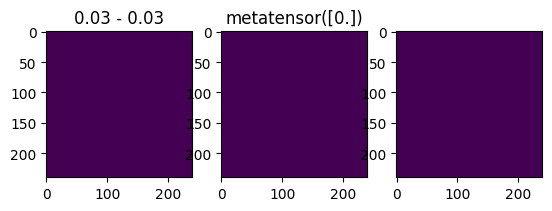

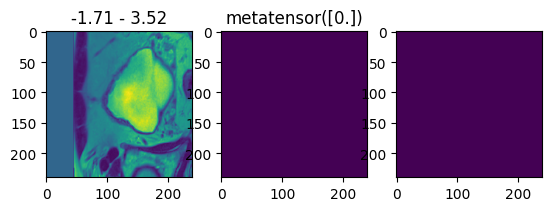

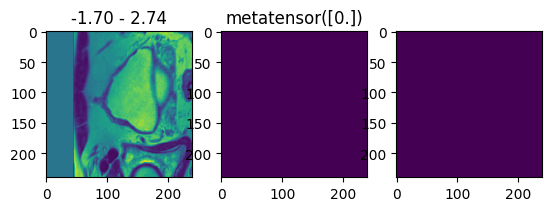

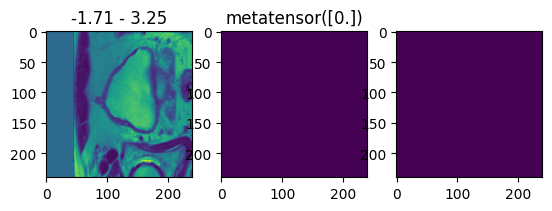

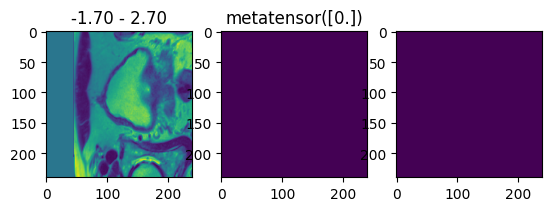

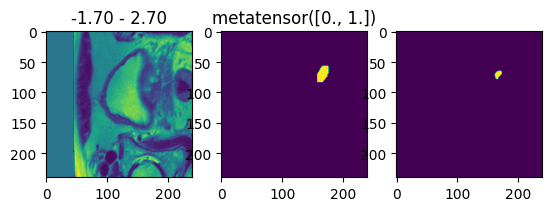

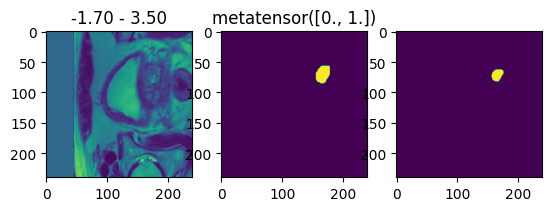

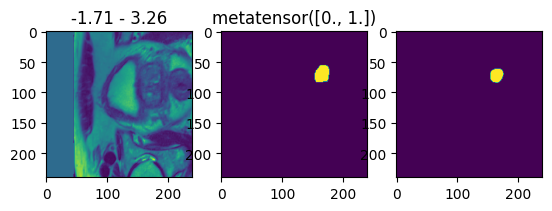

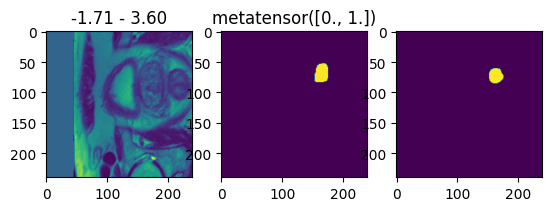

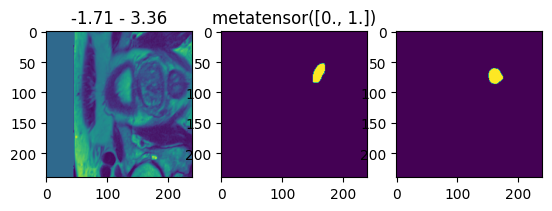

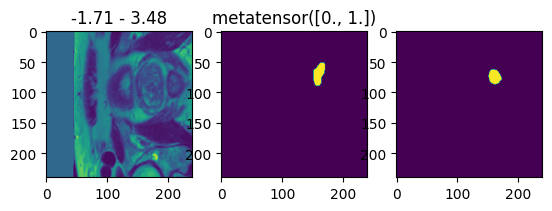

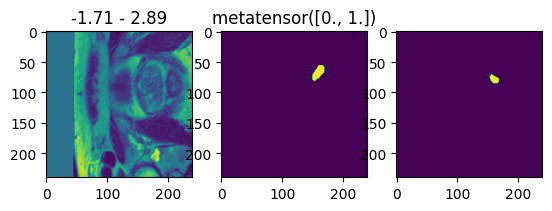

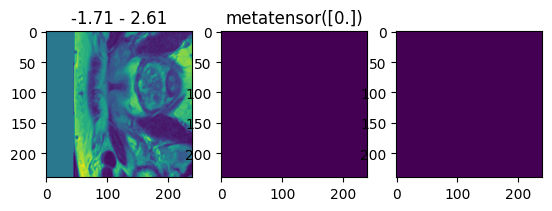

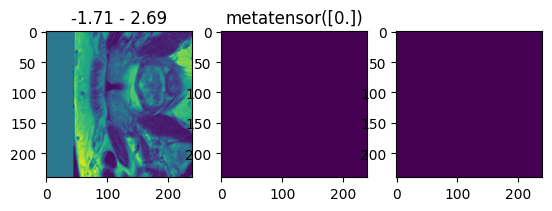

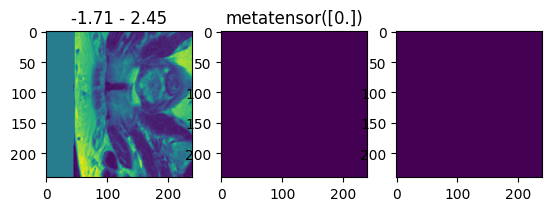

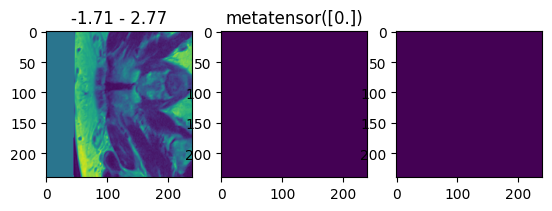

In [40]:
one_batch = ds[2]
for i in range(0,16):
    plt.figure()
    image = one_batch['image'][0]
    label = one_batch['label'][0]
    predict = model(one_batch['image'].unsqueeze(0).to('cuda'))[0][0]
    plt.subplot(131), plt.imshow(image[:,:,i]), plt.title(f"{image[:,:,i].min():.2f} - {image[:,:,i].max():.2f}")
    plt.subplot(132), plt.imshow(label[:,:,i]), plt.title(label[:,:,i].unique())
    plt.subplot(133), plt.imshow(predict[:,:,i].cpu().detach().numpy()>0), 